In [1]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# Choose to use a config and initialize the detector
config = 'configs/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'
# initialize the detector
detection_model = init_detector(config, checkpoint, device='cuda:0')

load checkpoint from local path: checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth


/home/aditya/robotics/mmdetection/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


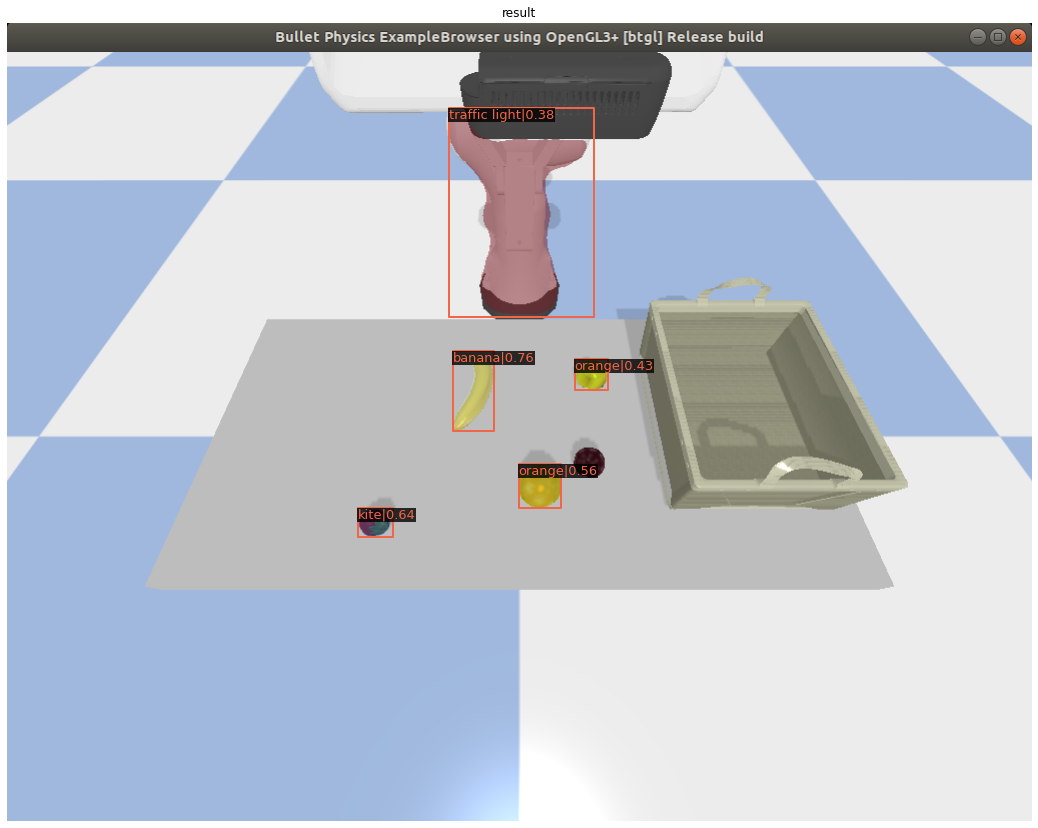

In [2]:
# Use the detector to do inference
img = 'saved_segments/2-1-1.png'
result = inference_detector(detection_model, img)
# Let's plot the result
show_result_pyplot(detection_model, img, result, score_thr=0.3)

In [3]:
# method for computing the intersection over union (IOU) for two bounding boxes
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

0 []
1 []
2 []
3 []
4 []
5 []
6 []
7 []
8 []
9 [[4.4130518e+02 8.5620461e+01 5.8671179e+02 2.9452307e+02 3.8370246e-01]]
10 []
11 [[6.3467267e+02 2.7572522e+02 8.9590717e+02 4.7741907e+02 1.1592979e-01]]
12 [[4.4413654e+02 6.2520294e+01 5.9346521e+02 2.8808109e+02 6.0682416e-02]]
13 []
14 []
15 []
16 []
17 []
18 []
19 []
20 []
21 []
22 []
23 []
24 []
25 []
26 []
27 []
28 []
29 []
30 []
31 []
32 []
33 [[350.5529     485.51328    385.00037    514.94354      0.63966656]]
34 []
35 []
36 []
37 []
38 []
39 []
40 []
41 []
42 []
43 []
44 []
45 []
46 [[445.2082     328.13147    486.51904    408.3599       0.75532097]]
47 [[5.6570319e+02 4.2423294e+02 5.9808978e+02 4.5591568e+02 1.0579449e-01]
 [5.6796436e+02 3.3654913e+02 6.0092029e+02 3.6859448e+02 1.0212632e-01]]
48 []
49 [[5.1111758e+02 4.4126028e+02 5.5348102e+02 4.8568411e+02 5.5941725e-01]
 [5.6796387e+02 3.3660745e+02 6.0070544e+02 3.6792642e+02 4.2505828e-01]]
50 []
51 []
52 []
53 []
54 [[5.6476111e+02 4.2388550e+02 5.9765717e+02 4.5466

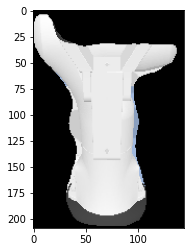

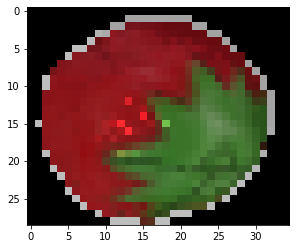

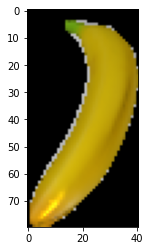

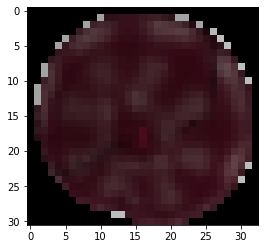

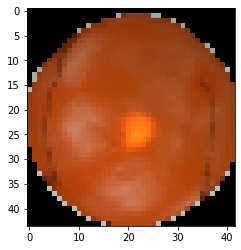

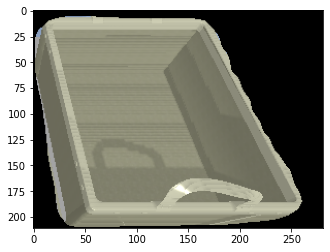

In [4]:
# Full code logic 
# Use the full object arrays and masks to generate the object segmentations 
# Extract the object bounding boxes and the corresponding masks 
# For two bounding boxes, check if the iou between them is greater than threshold, reject bb with lower score
# Generate the mask over the remaining bounding boxes
# Use the generated image segments for performing feature matching with the target mesh objects 
# This can be used for grasp verification as well as for object matching (replacing SuperGlue)
# Generate features using multiple networks (model ensembling) and combine their features 

import cv2
import matplotlib.pyplot as plt

img = 'saved_segments/2-1-1.png'
result = inference_detector(detection_model, img)

# Extract the full object arrays and masks 
not_none = 0
object_arrays = list()
object_masks = list()
for i, val in enumerate(result[0]):
    if len(val) != 0:
        not_none += 1
        object_arrays.append(val)
        object_masks.append(result[1][i])
    print(i, val)
print(f'Arrays that don\'t have zero length are : {not_none}')

first_objects = list()
first_masks = list()
for i, object_array in enumerate(object_arrays):
    print(i, object_array)
    first_objects.append(object_array[0])
    first_masks.append(object_masks[i][0])

# # Printing the extracted objects
# for i, first_object in enumerate(first_objects):
#     print(i, first_object)
    
# # Pring the extracted masks
# for i, first_mask in enumerate(first_masks):
#     print(i, first_mask)
    
# Compute the iou between two bounding boxes and remove the one with the lower confidence 
for bb1_index in range(len(first_objects)):
    for bb2_index in range(bb1_index+1, len(first_objects)):
        if first_objects[bb1_index] is None or first_objects[bb2_index] is None:
            continue

        bb1 = {'x1': int(first_objects[bb1_index][0]), 
       'x2': int(first_objects[bb1_index][2]), 
       'y1': int(first_objects[bb1_index][1]), 
       'y2': int(first_objects[bb1_index][3])}

        bb2 = {'x1': int(first_objects[bb2_index][0]), 
       'x2': int(first_objects[bb2_index][2]), 
       'y1': int(first_objects[bb2_index][1]), 
       'y2': int(first_objects[bb2_index][3])}
        
        iou = get_iou(bb1, bb2)
        if iou>=0.5:
            # set the bb with the lower confidence to None
            bounding_box1 = first_objects[bb1_index]
            bounding_box2 = first_objects[bb2_index]
            # print(f'The indices are : {bb1_index}, {bb2_index}')
            
            if bounding_box1[4] < bounding_box2[4]:
                first_objects[bb1_index] = None
                first_masks[bb1_index] = None
            else:
                first_objects[bb2_index] = None
                first_masks[bb2_index] = None

# Purge all bbs that are None
updated_bbs = [bb for bb in first_objects if bb is not None]
updated_masks = [mask for mask in first_masks if mask is not None]
print(len(updated_bbs), len(updated_masks))
print(updated_masks)

import random, os

save_dir_name = 'saved_segments/new_segments'
os.makedirs(save_dir_name, exist_ok=True)

# function to generate a 5 digit random alphanumeric number
def get_random(CHAR_LEN=5):
    chars = 'abcdefghijklmnopqrstuvwxyz0123456789'
    random_chars = list()
    for i in range(CHAR_LEN):
        random_chars.append(chars[random.randint(0, len(chars)-1)])

    random_filename = ''.join(random_chars)
    return random_filename
    
# image = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
# Generate the image segments for the generated object bbs and object masks

for i, sample_bb in enumerate(updated_bbs):
    image = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    object_mask = ~updated_masks[i]
    image[object_mask] = 0
    cropped_image = image[int(sample_bb[1]):int(sample_bb[3]), int(sample_bb[0]):int(sample_bb[2])]
    
    plt.figure()
    plt.imshow(cropped_image)
    
    # save the segmented image
    cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR)
    save_filepath = os.path.join(save_dir_name, str(get_random()) + '.jpg')
    cv2.imwrite(save_filepath, cropped_image)

In [5]:
# Build an ensemble network which consists of multiple pretrained feature extractor networks 
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image

scaler = transforms.Scale((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()


# generate the embedding from the vgg16 network 
def vgg16_embedding(image_name, ):
    # Load the pretrained model
    model = models.vgg16(pretrained=True)
    # Use the model object to select the desired layer
    layer = model._modules.get('avgpool')

    # Set model to evaluation mode
    model.eval()
    
    dimension = 25088

    return get_vector(image_name, dimension, layer, model)
    

# generate the embedding from the resnet network 
def resnet18_embedding(image_name):
    # Load the pretrained resnet18 model 
    model = models.resnet18(pretrained=True)
    # Use the model object to select the desired layer 
    layer = model._modules.get('avgpool')
    
    # set model to evaluation mode 
    model.eval()
    
    dimension = 512
    
    return get_vector(image_name, dimension, layer, model)
    
# generate the embedding from the Alexnet network 
def alexnet_embedding(image_name):
    # Load the pretrained faster rcnn model 
    model = models.alexnet(pretrained=True)
    # Use the model object to select the desired layer 
    layer = model._modules.get('avgpool')
    
    # set model to evaluation mode 
    model.eval() 
    
    dimension = 9216
    
    return get_vector(image_name, dimension, layer, model)


# generate the embedding from the Densenet network 
def densenet_embedding(image_name):
    # Load the pretrained faster rcnn model 
    model = models.densenet161(pretrained=True)
    # Use the model object to select the desired layer 
    layer = model._modules.get('features')
    
    # set model to evaluation mode 
    model.eval() 
    
    dimension = 108192
    
    return get_vector(image_name, dimension, layer, model)


# generate the embedding from the Inceptionnet network
def inceptionnet_embedding(image_name):
    # Load the pretrained faster rcnn model 
    model = models.inception_v3(pretrained=True)
    # Use the model object to select the desired layer 
    layer = model._modules.get('avgpool')
    
    # set model to evaluation mode 
    model.eval() 
    
    dimension = 2048
    
    return get_vector(image_name, dimension, layer, model)


def get_vector(image_name, dimension, layer, model):
    # 1. Load the image with Pillow library
    img = Image.open(image_name)
    # 2. Create a PyTorch Variable with the transformed image
    t_img = Variable(normalize(to_tensor(scaler(img))[:3]).unsqueeze(0))
    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(dimension)
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        # print(f'Shape of output : {o.data.shape}')
        # my_embedding.copy_(o.data.squeeze())
        # my_embedding.copy_(o.data.reshape(o.data.size(1)))
        my_embedding.copy_(o.data.view(-1))
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 6. Run the model on our transformed image
    model(t_img)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return my_embedding

image_dir_name = 'saved_segments'

# pic_one_vector = vgg16_embedding(os.path.join(image_dir_name, 'apple.jpg'))
# pic_two_vector = vgg16_embedding(os.path.join(image_dir_name, 'grey_plate.jpg'))

# pic_one_vector = resnet18_embedding(os.path.join(image_dir_name, 'blue_plate.jpg'))
# pic_two_vector = resnet18_embedding(os.path.join(image_dir_name, 'grey_plate.jpg'))

pic_one_vector = inceptionnet_embedding(os.path.join(image_dir_name, 'blue_plate.jpg'))
pic_two_vector = inceptionnet_embedding(os.path.join(image_dir_name, 'grey_plate.jpg'))

# Use the ranked scores from the classification network

# Using PyTorch Cosine Similarity
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
cos_sim = cos(pic_one_vector.unsqueeze(0),
              pic_two_vector.unsqueeze(0))
print('\nCosine similarity: {0}\n'.format(cos_sim))

/home/aditya/anaconda3/envs/uois3d/lib/python3.7/site-packages/torchvision/transforms/transforms.py:256: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +



Cosine similarity: tensor([0.9006])



In [7]:
# Given two images, find the cosine similarity between them 
def cosine_similarity(image1, image2, func):
    pic_one_vector = func(image1)
    pic_two_vector = func(image2)
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    cos_sim = cos(pic_one_vector.unsqueeze(0),
                  pic_two_vector.unsqueeze(0))
    # print('\nCosine similarity: {0}\n'.format(cos_sim))
    return cos_sim

In [ ]:
# Find the cross similarity between every pair of images 
from glob import glob

images = glob('saved_segments/*.jpg')

for i in range(len(images)):
    for j in range(i+1, len(images)):
        # find the cosine similarity between images[i] and images[j]
        cos_sim = cosine_similarity(images[i], images[j])
        print(f'Cosine similarity between {images[i]} and {images[j]} is {cos_sim}')

In [30]:
# Given segmented images in the scenes, compare the cosine similarity between the segmented images and the target 
from glob import glob
import numpy as np

segmented_dir = 'saved_segments/new_segments'
segment_images = glob(segmented_dir + '/*.jpg')
target_image = os.path.join('saved_segments/matches', 'orange.png')

# There are two voting functions that can be used
# Assign score to the highest-ranked object using a function 
# Aggregate ranks against each index, and use index with the lowest rank
majority_match = np.zeros(len(segment_images))
full_scores = np.zeros(len(segment_images))

match_indices = list()
feature_functions = [vgg16_embedding, resnet18_embedding, alexnet_embedding, densenet_embedding, inceptionnet_embedding]

for feature_function in feature_functions:
    print(f'Using feature function : {feature_function}')
    cosine_scores = np.array([])
    for index, img in enumerate(segment_images):
        cosine_sim = cosine_similarity(img, target_image, feature_function)
        cosine_scores = np.append(cosine_scores, cosine_sim.item())
#         print(f'Similarity between {img} and {target_image} is : {cosine_sim.item()}')
        
#     _, indices = torch.sort(cosine_scores)
#     print(indices)
    segment_match_index = np.argmax(cosine_scores)
    sorted_ranks = np.argsort(cosine_scores)
    sorted_ranks = np.argsort(sorted_ranks)
    full_scores += sorted_ranks
    majority_match[segment_match_index] += 1
#     print(cosine_scores)
#     match_indices.append(cosine_scores)

print(majority_match)
print(full_scores)
print(segment_images)

majority_vote_index = np.argmax(majority_match)
full_vote_index = np.argmax(full_scores)

print(f'Highest using majority vote : {os.path.basename(segment_images[majority_vote_index])}')
print(f'Highest using full vote : {os.path.basename(segment_images[full_vote_index])}')
print(f'Ground truth image : {os.path.basename(target_image)}')

Using feature function : <function vgg16_embedding at 0x7fe511e61b00>
Using feature function : <function resnet18_embedding at 0x7fe511e61c20>
Using feature function : <function alexnet_embedding at 0x7fe511e61d40>
Using feature function : <function densenet_embedding at 0x7fe511e61e60>
Using feature function : <function inceptionnet_embedding at 0x7fe511e61f80>
[0. 0. 5. 0. 0. 0.]
[10. 15. 25.  4. 12.  9.]
['saved_segments/new_segments/arm.jpg', 'saved_segments/new_segments/strawberry.jpg', 'saved_segments/new_segments/orange.jpg', 'saved_segments/new_segments/plum.jpg', 'saved_segments/new_segments/banana.jpg', 'saved_segments/new_segments/tray.jpg']
Highest using majority vote : orange.jpg
Highest using full vote : orange.jpg
Ground truth image : orange.png


In [27]:
from glob import glob
import numpy as np

segmented_dir = 'saved_segments/new_segments'
segment_images = glob(segmented_dir + '/*.jpg')
target_image = os.path.join('saved_segments/matches', 'plum.png')

print(len(segment_images))
print(segment_images)

arm_image = os.path.join(segmented_dir, 'plum.jpg')
print(cosine_similarity(arm_image, target_image, resnet18_embedding))

majority_vote = [0, 4, 1, 0, 0, 0]
full_ranks = [13, 21, 15,  3, 12, 11]

majority_index = np.argmax(majority_vote)
full_index = np.argmax(full_ranks)

print(f'Highest using majority vote : {os.path.basename(segment_images[majority_index])}')
print(f'Highest using full vote : {os.path.basename(segment_images[full_index])}')

6
['saved_segments/new_segments/arm.jpg', 'saved_segments/new_segments/strawberry.jpg', 'saved_segments/new_segments/orange.jpg', 'saved_segments/new_segments/plum.jpg', 'saved_segments/new_segments/banana.jpg', 'saved_segments/new_segments/tray.jpg']
tensor([0.5602])
Highest using majority vote : strawberry.jpg
Highest using full vote : strawberry.jpg
